In [1]:
import mne
import signal_metrics
from pathlib import Path
import bids
import pickle
import matplotlib.pyplot as plt
from eeg_fmri_cleaning import GradientRemover, utils
import numpy as np
import os
import eeg_fmri_cleaning.main as cleaner
from matplotlib.lines import Line2D

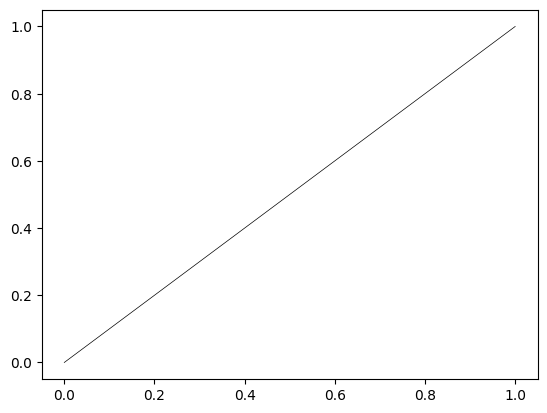

In [2]:
plt.plot([0, 1], [0, 1], color='black', linewidth=0.5)

In [3]:
def snr_spectrum(psd: mne.time_frequency.EpochsSpectrum,
                 noise_n_neighbor_freqs: int = 25, 
                 noise_skip_neighbor_freqs: int = 1) -> mne.time_frequency.EpochsSpectrumArray:
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : mne.time_frequency_EpochsSpectrum.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : mne.time_frequency.EpochsSpectrumArray
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd.get_data()
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)
    snr = mne.time_frequency.EpochsSpectrumArray(psd.get_data() / mean_noise,
                                                 psd.info,
                                                 psd.freqs)

    return snr

def get_snr_value_at_freq(snr: mne.time_frequency.EpochsSpectrum, 
                          stim_freq: int = 12) -> np.ndarray:
    """Get the SNR value at a specific frequency.
    
    Parameters
    ----------
    snr : mne.time_frequency.Spectrum
        SNR object as returned by snr_spectrum
    stim_freq : int
        Frequency of interest
    
    Returns
    -------
    snr_value : float
        SNR value at the frequency of interest
    """
    
    # find index of frequency bin closest to stimulation frequency
    i_bin_12hz = np.argmin(abs(snr.freqs - stim_freq))
    # could be updated to support multiple frequencies

    snrs_target = snr.get_data()[:, :, i_bin_12hz]
    return snrs_target.mean()

def plot_psd_comparison(data: dict, title:str = None):
    """Plot PSD comparison between several conditions.
    
    return figure
    """
    fig, axes = plt.subplots(figsize=(12, 4))
    colors = {
        'out scanner': '#2ca02c',
        'cbin-asr': '#9467bd',
        'raw': '#7f7f7f',
        'brainvision': '#ff7f0e',
    }
    legend_elements = list()
    for label, psd in data.items():
        psd.plot(show = False, axes = axes, average = True,
                 color = colors[label], ci = None, dB = True,
                 )
        legend_elements.append(Line2D([0], [0], color = colors[label], label=label))
    axes.set_title(title)
    
    plt.legend(handles=legend_elements)
    return fig
    


In [4]:
def get_psd_checker(raw):
    events, event_id = mne.events_from_annotations(raw)
    raw_cbin.set_eeg_reference(ref_channels="average")
    channel_selection = ['O1', 'Oz', 'O2', 'PO7', 'PO8', 'PO3', 'POz', 'PO4']
    
    events = mne.pick_events(events, include = event_id['S 25'])
    epochs = mne.Epochs(raw, events = events, 
                        event_id = {'stim': event_id['S 25']}, 
                        tmin = 0, 
                        tmax = 20,
                        baseline = (0,0),
                        verbose = "CRITICAL")
    spectrum_checker = epochs['stim'].compute_psd(fmax = 40, 
                                            picks = channel_selection,
                                            verbose = "CRITICAL")
    spectrum_checker_array = spectrum_checker.get_data()
    spectrum_checker = mne.time_frequency.EpochsSpectrumArray(
                                        spectrum_checker_array, 
                                        spectrum_checker.info, 
                                        spectrum_checker.freqs)
    return spectrum_checker

In [ ]:

dict_comparison = {
    'out scanner':list(),
    'cbin-asr':   list(),
    'raw':        list(),
    'brainvision':list(),
}

layout = bids.layout.BIDSLayout('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/GRAD_BCG_ASR/')
files = layout.get(task = 'checker')
bv_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/')
raw_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/')


for file in files:
    bv_filename = Path(file.filename).with_suffix('.edf')
    cbin_filename = Path(file.path).with_suffix('.fif')
    raw_filename = Path(file.path.replace('DERIVATIVES/GRAD_BCG_ASR','RAW')).with_suffix('.set')
    outside_scanner = Path(file.path.replace('checker','checkerout')).with_suffix('.set')
    outside_scanner = str(outside_scanner).replace('DERIVATIVES/GRAD_BCG_ASR', 'RAW')
    try:
        raw_cbin = mne.io.read_raw_fif(cbin_filename, preload = True, verbose = "CRITICAL")
        raw_cbin.apply_proj()
        dict_comparison['cbin-asr'] = get_psd_checker(raw_cbin)
        raw_bv = mne.io.read_raw_edf(bv_folder / bv_filename, preload = True, verbose = "CRITICAL")
        dict_comparison['brainvision'] = get_psd_checker(raw_bv)
        raw_raw = mne.io.read_raw_eeglab(raw_filename, preload = True)
        raw_raw.resample(250, verbose="CRITICAL")
        dict_comparison['raw'] = get_psd_checker(raw_raw)
        raw_outside_scanner = mne.io.read_raw_eeglab(outside_scanner, preload = True, verbose = "CRITICAL")
        raw_outside_scanner.resample(250, verbose="CRITICAL")
        dict_comparison['out scanner'] = get_psd_checker(raw_outside_scanner)
        fig = plot_psd_comparison(dict_comparison, file.filename)
        plt.savefig("/home/slouviot/01_projects/EEG_quality_assessment/figures_2/ssvep" + os.path.spliext(file.filename)[0] + ".png")
    except Exception as e:
        #raise e
        continue
plt.show()
        
        

In [45]:
%%capture
dict_comparison = {
    'out scanner':list(),
    'cbin-asr':   list(),
    'raw':        list(),
    'brainvision':list(),
}

layout = bids.layout.BIDSLayout('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/GRAD_BCG_ASR/')
files = layout.get(task = 'checker')
bv_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/')
raw_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/')


for file in files:
    bv_filename = Path(file.filename).with_suffix('.edf')
    cbin_filename = Path(file.path).with_suffix('.fif')
    raw_filename = Path(file.path.replace('DERIVATIVES/GRAD_BCG_ASR','RAW')).with_suffix('.set')
    outside_scanner = Path(file.path.replace('checker','checkerout')).with_suffix('.set')
    outside_scanner = str(outside_scanner).replace('DERIVATIVES/GRAD_BCG_ASR', 'RAW')
    try:
        raw_cbin = mne.io.read_raw_fif(cbin_filename, preload = True, verbose = "CRITICAL")
        raw_cbin.apply_proj()
        snr = snr_spectrum(get_psd_checker(raw_cbin))
        dict_comparison['cbin-asr'].append(get_snr_value_at_freq(snr, 18))
        raw_bv = mne.io.read_raw_edf(bv_folder / bv_filename, preload = True, verbose = "CRITICAL")
        snr = snr_spectrum(get_psd_checker(raw_bv))
        dict_comparison['brainvision'].append(get_snr_value_at_freq(snr))
        raw_raw = mne.io.read_raw_eeglab(raw_filename, preload = True)
        raw_raw.resample(250, verbose="CRITICAL")
        snr = snr_spectrum(get_psd_checker(raw_raw))
        dict_comparison['raw'].append(get_snr_value_at_freq(snr, 18))
        raw_outside_scanner = mne.io.read_raw_eeglab(outside_scanner, preload = True, verbose = "CRITICAL")
        raw_outside_scanner.resample(250, verbose="CRITICAL")
        snr = snr_spectrum(get_psd_checker(raw_outside_scanner))
        dict_comparison['out scanner'].append(get_snr_value_at_freq(snr, 18))
    except Exception as e:
        #raise e
        continue
        
        

In [22]:
test = np.array(dict_comparison['brainvision'])

Text(0.5, 1.0, 'Average SNR across subjects for noise at 18 Hz (lower is better)')

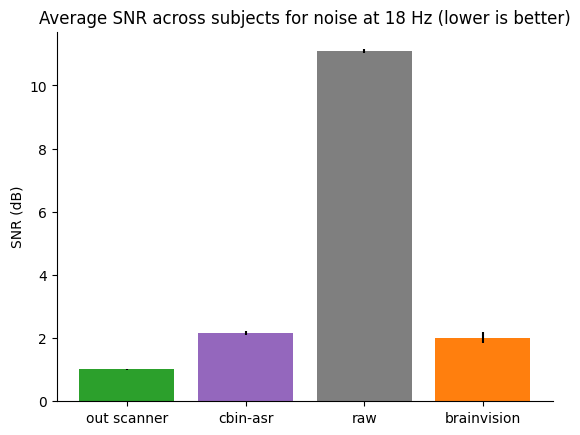

In [46]:
%matplotlib inline
mean_dict = {key: np.mean(val) for key, val in dict_comparison.items()}
std_dict = {key: np.std(val) for key, val in dict_comparison.items()}
standard_error = {key: val/np.sqrt(len(dict_comparison[key])) for key, val in std_dict.items()}
colors = {
'out scanner': '#2ca02c',
'cbin-asr': '#9467bd',
'raw': '#7f7f7f',
'brainvision': '#ff7f0e',
}

plt.subplots()
plt.bar(mean_dict.keys(), 
        mean_dict.values(), 
        yerr = standard_error.values(),
        color = [colors['out scanner'], 
                 colors['cbin-asr'], 
                 colors['raw'],
                 colors['brainvision']])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylabel('SNR (dB)')
plt.title('Average SNR across subjects for noise at 18 Hz (lower is better)')


In [48]:
mean_dict['out scanner']

1.0095616371129097

In [37]:
%%capture
dict_comparison = {
    'out scanner':list(),
    'cbin-asr':   list(),
    'raw':        list(),
    'brainvision':list(),
}

layout = bids.layout.BIDSLayout('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/GRAD_BCG_ASR/')
files = layout.get(task = 'checker')
bv_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/')
raw_folder = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW/')


for file in files:
    bv_filename = Path(file.filename).with_suffix('.edf')
    cbin_filename = Path(file.path).with_suffix('.fif')
    raw_filename = Path(file.path.replace('DERIVATIVES/GRAD_BCG_ASR','RAW')).with_suffix('.set')
    outside_scanner = Path(file.path.replace('checker','checkerout')).with_suffix('.set')
    outside_scanner = str(outside_scanner).replace('DERIVATIVES/GRAD_BCG_ASR', 'RAW')
    try:
        raw_cbin = mne.io.read_raw_fif(cbin_filename, preload = True, verbose = "CRITICAL")
        raw_cbin.apply_proj()
        psd = get_psd_checker(raw_cbin)
        dict_comparison['cbin-asr'].append(psd.get_data())
        raw_bv = mne.io.read_raw_edf(bv_folder / bv_filename, preload = True, verbose = "CRITICAL")
        psd = get_psd_checker(raw_bv)
        dict_comparison['brainvision'].append(psd.get_data())
        raw_raw = mne.io.read_raw_eeglab(raw_filename, preload = True)
        raw_raw.resample(250, verbose="CRITICAL")
        psd = get_psd_checker(raw_raw)
        dict_comparison['raw'].append(psd.get_data())
        raw_outside_scanner = mne.io.read_raw_eeglab(outside_scanner, preload = True, verbose = "CRITICAL")
        raw_outside_scanner.resample(250, verbose="CRITICAL")
        psd = get_psd_checker(raw_outside_scanner)
        dict_comparison['out scanner'].append(psd.get_data())
    except Exception as e:
        #raise e
        continue

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/tmp/ipykernel_160934/155140316.py:87: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(show = False, axes = axes, average = True,
/tmp/ipykernel_160934/155140316.py:87: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(show = False, axes = axes, average = True,
/tmp/ipykernel_160934/155140316.py:87: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(show = False, axes = axes, average = True,
/tmp/ipykernel_160934/155140316.py:87: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd.plot(show = False, axes = axes, average = True,


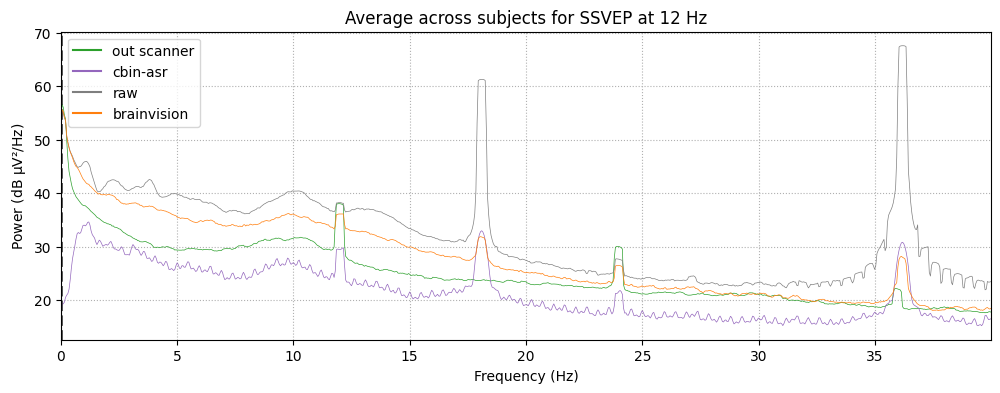

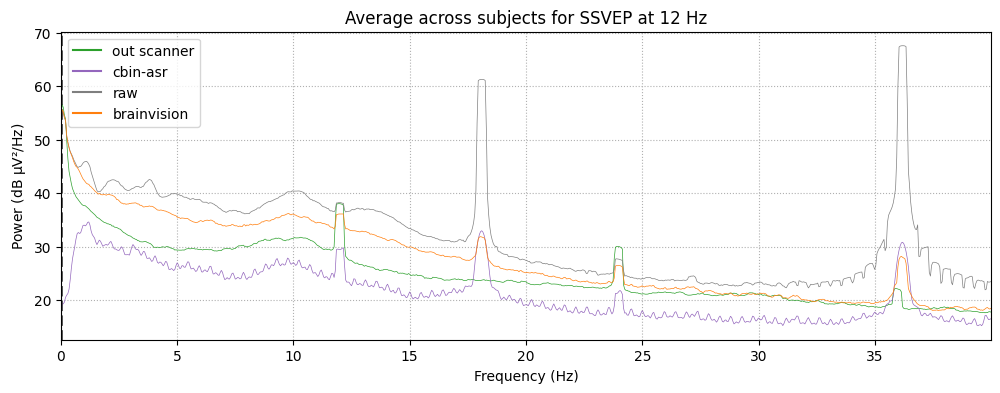

In [44]:
dict_plot = dict()
for key, val in dict_comparison.items():
    array = np.array(val)
    average = np.mean(array, axis = (0,1))
    psd_object = mne.time_frequency.SpectrumArray(average,
                                                        psd.info, 
                                                        psd.freqs)
    dict_plot[key] = psd_object

plot_psd_comparison(dict_plot, 'Average across subjects for SSVEP at 12 Hz')

In [49]:
10**(1.0095616371129097/10)

1.2617001762038949

In [32]:
key

'out scanner'

In [23]:
a = np.array(dict_comparison['cbin-asr'])

In [24]:
a.shape

(70, 5, 8, 801)

In [25]:
t = np.mean(a, axis = (0,1,2))

In [27]:
t.shape

(801,)